In [1]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../../src')
import harmoutil

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load data
raw_data = harmoutil.load_pickled_data("../../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
data = [harmoutil.to_sevenths(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

In [3]:
# Isolate meaningful data
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
unique_chords = sorted(list(set(chords)))

notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
unique_notes = sorted(list(set(notes)))

print("Unique notes ({}): {}".format(len(unique_notes), unique_notes))
print("Unique chords ({}): {}".format(len(unique_chords), unique_chords))

Unique notes (13): [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Unique chords (193): ['A', 'A+', 'A+7', 'A+j7', 'A-', 'A-6', 'A-7', 'A-j7', 'A6', 'A7', 'Ab', 'Ab+', 'Ab+7', 'Ab+j7', 'Ab-', 'Ab-6', 'Ab-7', 'Ab-j7', 'Ab6', 'Ab7', 'Abj7', 'Abm7b5', 'Abo', 'Abo7', 'Absus', 'Absus7', 'Aj7', 'Am7b5', 'Ao', 'Ao7', 'Asus', 'Asus7', 'B', 'B+', 'B+7', 'B+j7', 'B-', 'B-6', 'B-7', 'B-j7', 'B6', 'B7', 'Bb', 'Bb+', 'Bb+7', 'Bb+j7', 'Bb-', 'Bb-6', 'Bb-7', 'Bb-j7', 'Bb6', 'Bb7', 'Bbj7', 'Bbm7b5', 'Bbo', 'Bbo7', 'Bbsus', 'Bbsus7', 'Bj7', 'Bm7b5', 'Bo', 'Bo7', 'Bsus', 'Bsus7', 'C', 'C+', 'C+7', 'C+j7', 'C-', 'C-6', 'C-7', 'C-j7', 'C6', 'C7', 'Cj7', 'Cm7b5', 'Co', 'Co7', 'Csus', 'Csus7', 'D', 'D+', 'D+7', 'D+j7', 'D-', 'D-6', 'D-7', 'D-j7', 'D6', 'D7', 'Db', 'Db+', 'Db+7', 'Db+j7', 'Db-', 'Db-6', 'Db-7', 'Db-j7', 'Db6', 'Db7', 'Dbj7', 'Dbm7b5', 'Dbo', 'Dbo7', 'Dbsus', 'Dbsus7', 'Dj7', 'Dm7b5', 'Do', 'Do7', 'Dsus', 'Dsus7', 'E', 'E+', 'E+7', 'E+j7', 'E-', 'E-6', 'E-7', 'E-j7', 'E6', 'E7', 'Eb', 'Eb+', 'Eb+7

In [4]:
# Create categorical data mappings
note_to_int = dict([(c, i) for i, c in enumerate(unique_notes[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)

int_to_note = dict([(k, v) for v, k in note_to_int.items()])

chord_to_int = dict([(c, i) for i, c in enumerate(unique_chords)])
chord_to_int['<bos>'] = len(chord_to_int)

int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])

print("Melody note to integer mapping:\n {}\n".format(note_to_int))
print("Integer to melody note mapping:\n {}\n".format(int_to_note))
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<pad>': 13, -1: 12}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'Do7': 109, 'Bb+j7': 45, 'C7': 73, 'Cj7': 74, 'Ab+j7': 13, 'C-': 68, 'Gbm7b5': 181, 'G': 160, 'B6': 40, 'Em7b5': 139, 'Go': 188, 'NC': 192, 'G+7': 162, 'Ab6': 18, 'F7': 153, 'D+7': 82, 'Gbo': 182, 'D': 80, 'Eo7': 141, 'Bbsus': 56, 'Gb': 170, 'A+': 1, 'Bb-7': 48, 'E+j7': 115, 'Ebsus': 136, 'Eb+7': 124, 'Asus7': 31, 'Dsus7': 111, 'Eb-6': 127, 'Bb7': 51, 'Dm7b5': 107, 'D-7': 86, 'Bbo7': 55, 'Esus': 142, 'A-j7': 7, 'E7': 121, 'G-7': 166, 'Gbsus': 184, 'E+7': 114, 'Gb-7': 176, 'Abo7': 23, 'A': 0, 'Gb+7': 172, 'A6': 8, 'Db': 90, 'Eo': 140, 'Absus7': 25, 'D+': 81, 'Ab+7': 12, 'Gbj7': 180, 'Bb+': 43, 'B-': 36, 'Bbo': 54, 'Bsus7': 63, 'G+': 161, 'G-': 164, 'Gb6': 178, 'Bo7': 61, 'Ebm7b5': 133, 'Db+': 9

In [5]:
# Refine data that will actually be used
def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False

def check_if_NC(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "NC" in ch:
            return True
    return False

# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
section_data = [section for section in data if not check_if_augmented_major(section)]
print("Number of sections: {}\n".format(len(section_data)))

section_data = [section for section in section_data if not check_if_NC(section)]
print("Number of sections: {}\n".format(len(section_data)))

chords_by_sections = [get_chords_by_section(section) for section in section_data]
chords_data = [chord_info[0] for section in section_data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in section_data for chord_info in section]

Number of sections: 28836

Number of sections: 28416



In [6]:
# Define numerical variables

n_samples = len(chords_data)
n_chords = len(chord_to_int)
n_notes = len(note_to_int)
max_mel_len = max([len(mel) for mel in notes_by_chords])
chord_context_len = 7

# print("Total number of samples: {}".format(n_samples))
print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Maximum length of melody sequences for one chord: {}".format(max_mel_len))
print("Number of past chords given as input: {}".format(chord_context_len))

Total number of samples: 327708
Number of distinct melody notes: 14
Number of distinct chord labels: 194
Maximum length of melody sequences for one chord: 115
Number of past chords given as input: 7


In [7]:
# Prepare tensor data
def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_sequence = context_len*['<bos>'] + chord_seq
    formatted_sequences = [padded_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_sequences

# Melody
input_melody_data = [pad_melody(melody, max_mel_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[5]))

# Chords
formatted_chords_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)
    
input_chords_data = [ch[:-1] for ch in formatted_chords_data]
target_chords_data = [ch[-1] for ch in formatted_chords_data]
print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))

print("Input melody: {}, Input chords: {}, Target chords: {}".format(len(input_melody_data), len(input_chords_data), len(target_chords_data)))

Sample input melody sequence: [8, 3, 6, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [8]:
# Load embedding vectors

num_dim = 32
num_ch = 192
num_notes = 12

# Define embedding training model and load weights
input_layer = Input(shape=(num_ch,)) 
embeddings_layer = Dense(num_dim, activation='linear', name="embeddings")(input_layer)
root_output_layer = Dense(num_notes, activation='softmax')(embeddings_layer)
interval_output_layer = Dense(num_notes, activation='sigmoid')(embeddings_layer)
pitch_output_layer = Dense(num_notes, activation='sigmoid')(embeddings_layer)
melody_output_layer = Dense(num_notes, activation='relu')(embeddings_layer)
embeddings_model = Model(input_layer, [root_output_layer, interval_output_layer, pitch_output_layer, melody_output_layer])

embeddings_model.load_weights("../../../chord_embeddings_training/combined_embeddings/combined_weights_dim32.h5")

X_chords_embeddings = embeddings_model.layers[1].get_weights()[0]
print(X_chords_embeddings.shape)


(192, 32)


In [9]:
# Build tensors

n_dimensions = X_chords_embeddings.shape[1]
print("Size of embedding vector for each chord: {}".format(n_dimensions))

X_melody = np.zeros((n_samples, max_mel_len, n_notes), dtype='float32')
X_embeds = np.zeros((n_samples, chord_context_len, n_dimensions), dtype='float32')
Y_labels = np.zeros((n_samples, n_chords), dtype='float32')

for i, (input_mel, input_ch, target_ch) in enumerate(zip(input_melody_data, input_chords_data, target_chords_data)):
    Y_labels[i, chord_to_int[target_ch]] = 1
    for j, chord in enumerate(input_ch):
        chord_index = chord_to_int[chord]
        if (chord_index < num_ch):
            X_embeds[i, j, :] = X_chords_embeddings[chord_index, :]
        
    for j, note in enumerate(input_mel):
        X_melody[i, j, note_to_int[note]] = 1


Size of embedding vector for each chord: 32


In [10]:
# Split dataset into 80%-10%-10% train-valid-test

seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_embeds, Y_labels):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    X_embeds_train, X_embeds_aux = X_embeds[train_index], X_embeds[aux_index]
    Y_labels_train, Y_labels_aux = Y_labels[train_index], Y_labels[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_embeds_aux, Y_labels_aux):
    X_melody_valid, X_melody_test = X_melody_aux[valid_index], X_melody_aux[test_index]
    X_embeds_valid, X_embeds_test = X_embeds_aux[valid_index], X_embeds_aux[test_index]
    Y_labels_valid, Y_labels_test = Y_labels_aux[valid_index], Y_labels_aux[test_index]

In [11]:
# Define neural net architecture

latent_dim = 128

melody_input = Input(shape=(max_mel_len, n_notes))
melody_gru1 = GRU(latent_dim, return_sequences=True)(melody_input)
melody_gru2 = GRU(latent_dim, return_sequences=True)(melody_gru1)
melody_gru3 = GRU(latent_dim)(melody_gru2)

embed_input = Input(shape=(chord_context_len, n_dimensions))
embed_gru1 = GRU(latent_dim, return_sequences=True)(embed_input)
embed_gru2 = GRU(latent_dim, return_sequences=True)(embed_gru1)
embed_gru3 = GRU(latent_dim)(embed_gru2)

concat = concatenate([melody_gru3, embed_gru3])

label_hidden1 = Dense(latent_dim, activation='relu')(concat)
label_hidden2 = Dense(latent_dim, activation='relu')(label_hidden1)
label_dense = Dense(n_chords, activation='softmax')(label_hidden2)

model = Model([melody_input, embed_input], label_dense)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 115, 14)       0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 7, 32)         0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 115, 128)      54912       input_2[0][0]                    
____________________________________________________________________________________________________
gru_4 (GRU)                      (None, 7, 128)        61824       input_3[0][0]                    
___________________________________________________________________________________________

In [12]:
# Introduce Save-Best-Performance callbacks
filepath = "Embed_depth3.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [13]:
# Train model
batch_size = 256
epochs = 150

history = model.fit([X_melody_train, X_embeds_train], Y_labels_train, epochs=epochs, validation_data=([X_melody_valid, X_embeds_valid], Y_labels_valid,), batch_size=batch_size, callbacks=[bp])

Train on 262166 samples, validate on 32771 samples
Epoch 1/150
262166/262166 [==============================] - 427s - loss: 2.8997 - acc: 0.3375 - val_loss: 2.4115 - val_acc: 0.4383
Epoch 2/150
262166/262166 [==============================] - 429s - loss: 2.2033 - acc: 0.4765 - val_loss: 2.1035 - val_acc: 0.4955
Epoch 3/150
262166/262166 [==============================] - 430s - loss: 1.9096 - acc: 0.5424 - val_loss: 1.8833 - val_acc: 0.5509
Epoch 4/150
262166/262166 [==============================] - 427s - loss: 1.7013 - acc: 0.5906 - val_loss: 1.7324 - val_acc: 0.5906
Epoch 5/150
262166/262166 [==============================] - 424s - loss: 1.5487 - acc: 0.6257 - val_loss: 1.6386 - val_acc: 0.6101
Epoch 6/150
262166/262166 [==============================] - 424s - loss: 1.4341 - acc: 0.6503 - val_loss: 1.5640 - val_acc: 0.6333
Epoch 7/150
262166/262166 [==============================] - 425s - loss: 1.3486 - acc: 0.6683 - val_loss: 1.4629 - val_acc: 0.6500
Epoch 8/150
262166/262166

262166/262166 [==============================] - 416s - loss: 0.3772 - acc: 0.8891 - val_loss: 1.2861 - val_acc: 0.7776
Epoch 59/150
262166/262166 [==============================] - 415s - loss: 0.3633 - acc: 0.8925 - val_loss: 1.2853 - val_acc: 0.7758
Epoch 60/150
262166/262166 [==============================] - 413s - loss: 0.3915 - acc: 0.8843 - val_loss: 1.3021 - val_acc: 0.7690
Epoch 61/150
262166/262166 [==============================] - 415s - loss: 0.3576 - acc: 0.8943 - val_loss: 1.3048 - val_acc: 0.7743
Epoch 62/150
262166/262166 [==============================] - 414s - loss: 0.3637 - acc: 0.8926 - val_loss: 1.3064 - val_acc: 0.7730
Epoch 63/150
262166/262166 [==============================] - 415s - loss: 0.3680 - acc: 0.8909 - val_loss: 1.3089 - val_acc: 0.7760
Epoch 64/150
262166/262166 [==============================] - 414s - loss: 0.3747 - acc: 0.8895 - val_loss: 1.3362 - val_acc: 0.7633
Epoch 65/150
262166/262166 [==============================] - 414s - loss: 0.4288 

262166/262166 [==============================] - 419s - loss: 0.5290 - acc: 0.8487 - val_loss: 1.2684 - val_acc: 0.7755
Epoch 91/150
262166/262166 [==============================] - 418s - loss: 0.3391 - acc: 0.8994 - val_loss: 1.2623 - val_acc: 0.7862
Epoch 92/150
262166/262166 [==============================] - 418s - loss: 0.3219 - acc: 0.9048 - val_loss: 1.3163 - val_acc: 0.7784
Epoch 93/150
262166/262166 [==============================] - 417s - loss: 0.3406 - acc: 0.8983 - val_loss: 1.3280 - val_acc: 0.7752
Epoch 94/150
262166/262166 [==============================] - 418s - loss: 0.3473 - acc: 0.8964 - val_loss: 1.3626 - val_acc: 0.7698
Epoch 95/150
262166/262166 [==============================] - 418s - loss: 0.3562 - acc: 0.8942 - val_loss: 1.3048 - val_acc: 0.7809
Epoch 96/150
262166/262166 [==============================] - 419s - loss: 0.3377 - acc: 0.8996 - val_loss: 1.3289 - val_acc: 0.7791
Epoch 97/150
262166/262166 [==============================] - 418s - loss: 0.3250 

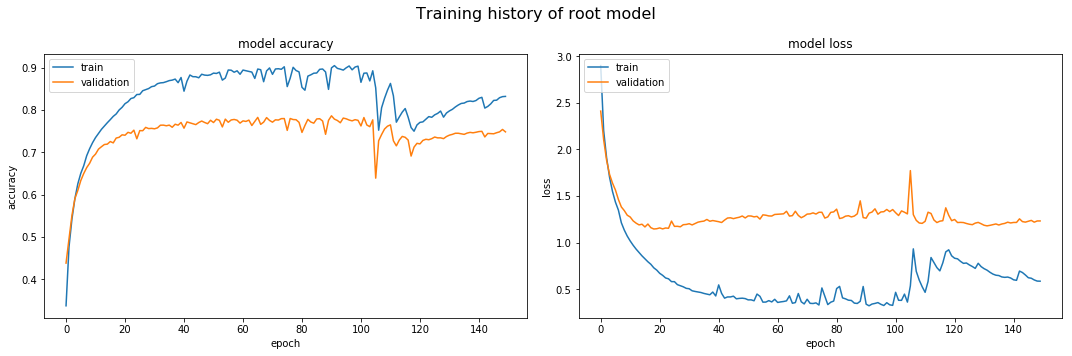

In [14]:
# Visualize model learning
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [15]:
# Load best performance model
best_model = load_model("Embed_depth3.h5")

In [16]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_labels_pred = best_model.predict([X_melody_test, X_embeds_test])

# Compute accuracy and kappa score
print("Categorical accuracy of combined chord label prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_labels_test, Y_labels_pred)))
print("Kappa score of combined chord label prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_labels_test, Y_labels_pred)))

Categorical accuracy of combined chord label prediction: 0.7860
Kappa score of combined chord label prediction: 0.7807


In [17]:
# Evaluate predictions in terms of pitches

def label_to_pitch_tensors(predictions):
    predicted_chords = [int_to_chord[np.argmax(ch)] for ch in predictions]
    pitch_chords = [harmoutil.chord_to_notes(label) for label in predicted_chords]
    
    Y_pitches = np.zeros((predictions.shape[0], 12), dtype='float32')
    for i, chord_pitches in enumerate(pitch_chords):
        for j, pitch_presence in enumerate(chord_pitches):
            Y_pitches[i, j] = pitch_presence

    return Y_pitches
    
    
Y_labels_pred_pitch = label_to_pitch_tensors(Y_labels_pred)
Y_labels_test_pitch = label_to_pitch_tensors(Y_labels_test)

print("Categorical accuracy of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_labels_test_pitch, Y_labels_pred_pitch)))
print("Kappa score of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_labels_test_pitch, Y_labels_pred_pitch)))

Categorical accuracy of combined chord pitch prediction: 0.9236
TP: 113395 TN: 249821 FP: 15071 FN: 14965
Kappa score of combined chord pitch prediction: 0.8263
